## Prepare Train Test Data

### import library

In [22]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np


In [18]:
# Set parameters
BATCH_SIZE = 64
input_shape = (224, 224, 3)
n_classes = 10  # Assuming we are using 10 classes
n_epochs = 10   # Reduced for quicker training on subset

# Paths for training and testing directories
download_dir = Path('datasets')  # Replace with your actual directory path
train_data_dir = download_dir / 'train'
val_data_dir = download_dir / 'val'

In [19]:
# Create ImageDataGenerator with preprocessing for VGG16 and split
train_generator = ImageDataGenerator(rescale=1./255,rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)

# Val data generator
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


In [20]:
# Set up training and validation data generators
traingen = train_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=42
)

validgen = val_generator.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [26]:
# Model creation function
def create_model(input_shape, optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Load the VGG16 model with pretrained ImageNet weights
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze layers based on the fine-tuning parameter
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        #freeze all layers except last 10
        for layer in conv_base.layers:
            layer.trainable = False

    # Add custom layers on top of the convolutional base
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    # Define the complete model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [27]:
# Initialize the optimizer
optim_1 = SGD(learning_rate=0.01, momentum=0.9)

# Instantiate the model with no fine-tuning
vgg_model = create_model(input_shape, optimizer=optim_1, fine_tune=0)

# Set up checkpoints and early stopping
checkpoint = ModelCheckpoint('vgg16_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

# Train the model
history = vgg_model.fit(
    traingen,
    steps_per_epoch=n_steps,
    epochs=n_epochs,
    validation_data=validgen,
    validation_steps=n_val_steps,
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
vgg_model.save('vgg16_model.keras')

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5072s 16s/step - accuracy: 0.4986 - loss: 0.8390 - val_accuracy: 0.5052 - val_loss: 3.0685
Epoch 2/10
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:06:15 13s/step - accuracy: 0.4844 - loss: 0.6931

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


312/312 ━━━━━━━━━━━━━━━━━━━━ 53s 131ms/step - accuracy: 0.4844 - loss: 0.6931 - val_accuracy: 0.7500 - val_loss: 2.4314
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5148s 17s/step - accuracy: 0.5008 - loss: 0.6933 - val_accuracy: 0.5090 - val_loss: 2.8874
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3750 - loss: 0.6948 - val_accuracy: 0.7500 - val_loss: 1.9231
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5144s 16s/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.5092 - val_loss: 2.8878
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4844 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 4.1809
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5091s 16s/step - accuracy: 0.5033 - loss: 0.6933 - val_accuracy: 0.5094 - val_loss: 2.8936
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4375 - loss: 0.6942 - val_accuracy: 0.3750 - val_loss: 3.8237
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5133s 16s/step - accuracy: 0.4949 - loss: 0.6932 - val_accur

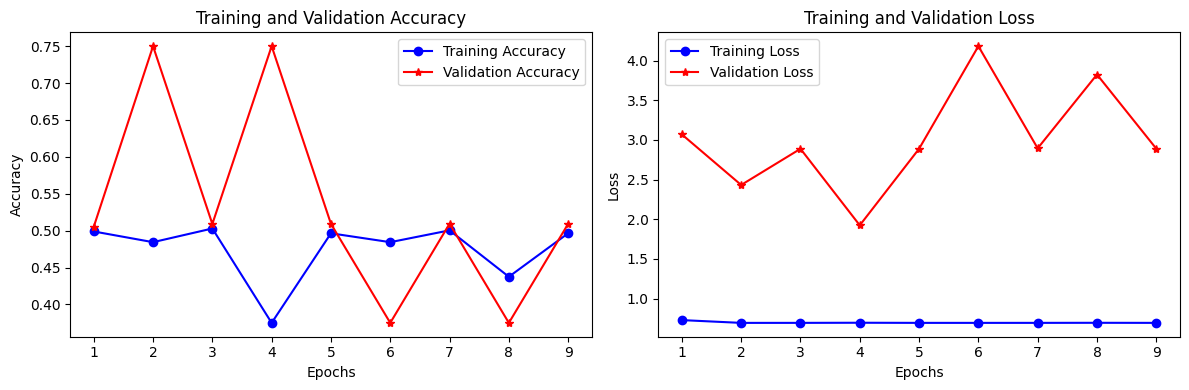

In [28]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()